 # Heart Disease Prediction
 *Clément POIRET | 11/09/2019*

 ## Université de Rouen - Programmation et Visualisation de données

 The dataset is publically available on the Kaggle website, and it is
 from an ongoing cardiovascular study on residents of the town of Framingham,
 Massachusetts. The classification goal is to predict whether the patient
 has 10-year risk of future coronary heart disease (CHD).The dataset provides
 the patients’ information. It includes over 4,000 records and 15 attributes.
 Variables Each attribute is a potential risk factor. There are both
 demographic, behavioral and medical risk factors.

 [The original dataset can be found here.](https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression)

 Original authors focused on a classical approach: a logistic regression to
 determine if patients were at risk to develop CHD diseases in a 10-year
 time frame. My approach is different to meet course's specifications:
 using *DataViz* to answer a personal problematic.
 My approach is using unsupervised machine learning to detect individuals
 with a high risk of CHD through *t-distributed stochastic neighbor embedding*
 (t-SNE), *density-based spatial clustering of applications with noise* (DBSCAN)
 and *self-organizing maps* (SOM).

 Copyright (C) 2019 POIRET Clément.

 This program is free software: you can redistribute it and/or modify
 it under the terms of the GNU Affero General Public License as published
 by the Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 This program is distributed in the hope that it will be useful,
 but WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 GNU Affero General Public License for more details.

 You should have received a copy of the GNU Affero General Public License
 along with this program.  If not, see <https://www.gnu.org/licenses/>.

 For clarity purposes, the code is splitted in two modules:
 * *utils.helpers* for various functions such a preprocessing pipelines,
 * *utils.models* for the implementation of t-SNE, DBCAN and SOM,
 * *utils.som.minisom* as a minisom implementation that can be [found here](https://github.com/JustGlowing/minisom).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import researchpy as rp
import seaborn as sns
import dabest
from pandas.plotting import andrews_curves
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import utils.helpers as hp
import utils.models as md

SEED = 0


 ## Data preparation
 The following cell is dealing with data preparation:
 * Reading the dataset,
 * Inserting an arbitrary id,
 * Splitting the dataset into features and original risk factor determined by the original authors,
 * Applying a pipeline defined in the helpers.py module:
   * Simple imputer with mean strategy to deal with missing data,
   * One Hot Encoder for categorical variables,
   * Standard Scaler.

In [2]:
dataset = pd.read_csv("data/framingham.csv")

# Inserting an ID to be able to get back individual patients.
dataset.insert(loc=0, column='id', value=[i for i in range(len(dataset))])

# Splitting the dataset. Let X be our working dataset. y are results obtained by the original creator of the dataset.
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Scaling the dataset using a One Hot Encoder and a Standard Scaler.
X, sc = hp.pipeline(X, onehotcolumn=3)


 ## t-distributed Stochastic Neighbor Embedding
 Defined in models.py, t-SNE is used for dimensionality reduction to remove over-correlations between variables,
 and reduce risks related to the curse of dimensionality.

In [3]:
X_tsne = md.reduct(X, seed=SEED)


 ## Density-Based Spatial Clustering of Applications with Noise
 DBSCAN is used on dimensionality reduced dataset to explicitly define clusters while beeing resistant to noise.

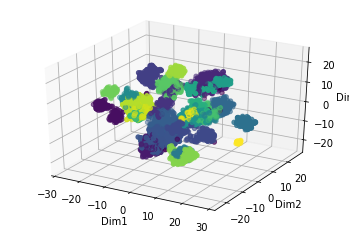

In [4]:
m = md.clusterize(X_tsne)

hp.plot3d(X_tsne, m)


 ## Self-Organizing Map
 Due to the nature of CHD, we can consider that CHD is naturally observed as outliers.
 Often referred as a part of unsupervised Deep Learning, SOMs are used here to detect outliers.

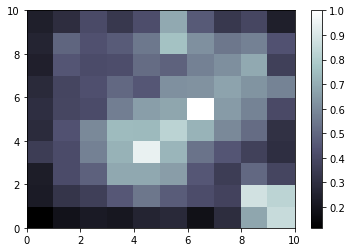

In [5]:
dmap, mappings = md.som(X, seed=SEED)


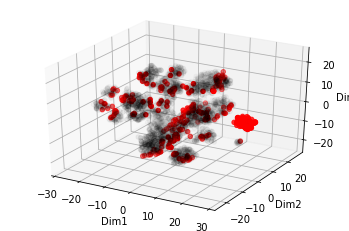

In [6]:
# Getting outliers based on the maximum distance returned by the map
chd = mappings[(np.where(dmap == np.amax(dmap))[1][0],
                np.where(dmap == np.amax(dmap))[0][0])]
chd = sc.inverse_transform(chd)

# Creating a binomial variable binding every patient to 1 if it is an outlier, 0 otherwise.
risky = [1 if dataset.iloc[i, 0] in chd else 0 for i in range(len(dataset))]

hp.plot3d(X_tsne, risky, colors=["#0000000D", "#FF0000FF"], cmap=True)


 At this point, we can compare our results with results obtained by the authors using a confusion matrix

In [7]:
cm = confusion_matrix(y, risky)
accuracy = np.trace(cm) / len(dataset)

print(accuracy)


0.8076923076923077


 For prevention purposes, we can return a dataframe containing both IDs and risks to offer patients in-depth tests and regular monitoring to prevent or manage coronary heart diseases as quickly as possible.

In [8]:
risk = pd.DataFrame({"id": dataset.iloc[:, 0], "cluster": m, "risk": risky})
print(risk.head(), "\n...", risk.tail())


id  cluster  risk
0   0        0     1
1   1        1     1
2   2        2     1
3   3        3     1
4   4        4     0 
...         id  cluster  risk
4233  4233        8     0
4234  4234       22     0
4235  4235        7     0
4236  4236       19     0
4237  4237        1     0


 According to our potential theoretical framework, we can also enhance our model by defining the DBSCAN cluster containing a majority of risky individuals as a cluster of interest. All individuals in this cluster will be considered "at risk" while others may be considered as simple noise affecting our SOM.

 Individuals flagged by the SOM may be called for an in-depth exam, while individuals in the DBSCAN cluster may be considered as needing a regular monitoring by a healthcare professional.

All individuals of the 9th group are at risk.


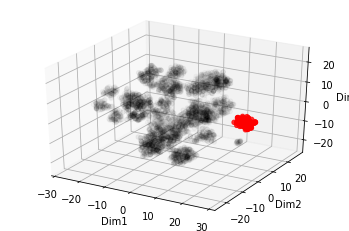

In [9]:
clusters = risk.groupby(["cluster"]).agg({"risk": sum, "id": "count"})

interest = clusters.index[np.where(
    clusters.iloc[:, 0] == clusters.iloc[:, 0].max())[0][0]]

print("All individuals of the {}th group are at risk.".format(interest))

dbscan_results = [1 if c == interest else 0 for c in m]
hp.plot3d(X_tsne, dbscan_results, colors=["#0000000D", "#FF0000FF"], cmap=True)


In [10]:
# we can compare our results again...
cm = confusion_matrix(y, dbscan_results)
accuracy = np.trace(cm) / len(dataset)

print(accuracy)

# We can also combine results...
combined = np.array(dbscan_results) | np.array(risky)


0.8390750353940538


 ## Deeper analysis of the cluster

In [11]:
df = dataset.iloc[:, 1:-1]
df["risk"] = risky
df = df.fillna(df.mean())
print(df.head())


male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   risk  
0     1  
1     1  
2     1  
3     1  
4  

 Due to the abstract nature of dimensions, it may not be possible to visually see differences between risk factors.

In [12]:
corr = df.corr().iloc[:-1, -1]
print(corr)


male              -0.038507
age                0.063409
education         -0.009882
currentSmoker     -0.025865
cigsPerDay        -0.006495
BPMeds             0.507787
prevalentStroke   -0.010621
prevalentHyp       0.130471
diabetes           0.009193
totChol            0.057434
sysBP              0.126158
diaBP              0.078823
BMI                0.056300
heartRate         -0.001080
glucose           -0.014018
Name: risk, dtype: float64


 Plotting some distributions to visually understand where is the risk coming from.

Plotting distributions or catplots according to variables of interest determined on Pearson Correlations with a threshold of .12.
Summary of BPMeds, grouped by risk:


         N      Mean        SD        SE  95% Conf.  Interval
risk                                                         
0     3913  0.004971  0.067731  0.001083   0.002849  0.007094
1      325  0.326519  0.469284  0.026031   0.275419  0.377618
Summary of prevalentHyp, grouped by risk:


         N      Mean        SD        SE  95% Conf.  Interval
risk                                                         
0     3913  0.293125  0.455254  0.007278   0.278859  0.307392
1      325  0.520000  0.500370  0.027756   0.465515  0.574485
Summary of sysBP, grouped by risk:


         N        Mean         SD        SE   95% Conf.    Interval
risk                                                               
0     3913  131.551239  21.293652  0.340404  130.883961  132.218517
1      325  141.998462  27.849200  1.544796  138.96

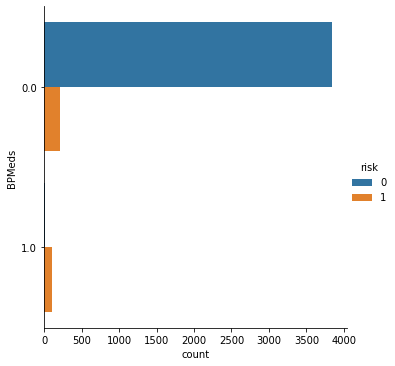

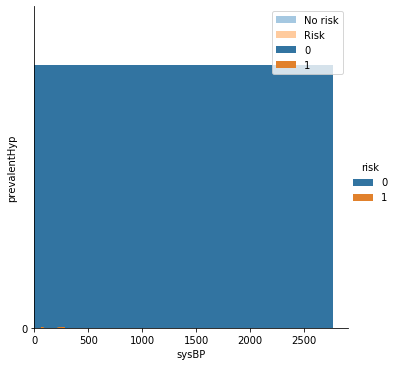

In [16]:
# Selecting variables of interest with a threshold of .12
print(
    "Plotting distributions or catplots according to variables of interest determined on Pearson Correlations with a threshold of .12."
)
vars = corr[(corr > .12) | (corr < -.12)].index

for var in vars:
    print("Summary of {}, grouped by risk:".format(var))
    print(rp.summary_cont(df[var].groupby(df["risk"])))

    # Check if the variable is continuous of binomial to use the correct plot
    if len(set(df[var])) > 3:
        sns.distplot(df[df.risk == 0][var], label="No risk")
        sns.distplot(df[df.risk == 1][var], label="Risk")
        plt.legend()
        plt.show()

    else:
        d = df[(df[var] == 0) | (df[var] == 1)]
        sns.catplot(y=var, hue="risk", kind="count", data=d)


We can also use Andrews Plots to compare our predictions with original results https://www.wikiwand.com/en/Andrews_plot

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 15))

# Computing Andrew's Curves for the original group
sc = MinMaxScaler()
cols = df.columns
X_2 = pd.DataFrame(sc.fit_transform(df))
X_2.risk = dataset.TenYearCHD
X_2.columns = cols
andrews_curves(X_2, 'risk', colormap='Set1', ax=axes[0, 0])

X_2.risk = risky
andrews_curves(X_2, 'risk', colormap='Set1', ax=axes[0, 1])

X_2.risk = dbscan_results
andrews_curves(X_2, 'risk', colormap='Set1', ax=axes[1, 0])

X_2.risk = combined
andrews_curves(X_2, 'risk', colormap='Set1', ax=axes[1, 1])

ValueError: could not convert string to float: 'Alert'

 In this dataset, 10years CHD seems highly linked to blood pressure (sysBP),
 already known hypertension (prevalentHyp) and medication (BPMeds).
 Let's explore the data through estimation statistics.

/home/clementpoiret/anaconda3/lib/python3.7/site-packages/seaborn/utils.py:238: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  maj_on = any(t.tick1On for t in ax_i.yaxis.majorTicks)
/home/clementpoiret/anaconda3/lib/python3.7/site-packages/seaborn/utils.py:239: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  min_on = any(t.tick1On for t in ax_i.yaxis.minorTicks)
/home/clementpoiret/anaconda3/lib/python3.7/site-packages/seaborn/utils.py:242: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = maj_on
/home/clementpoiret/anaconda3/lib/python3.7/site-packages/seaborn/utils.py:244: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 a

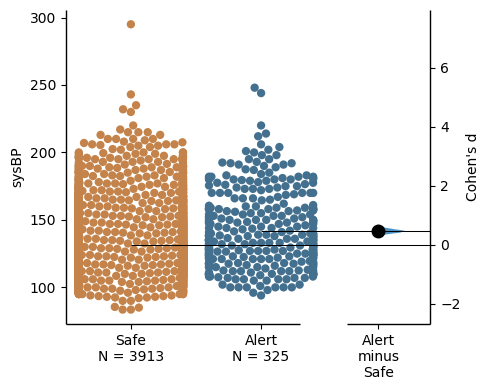

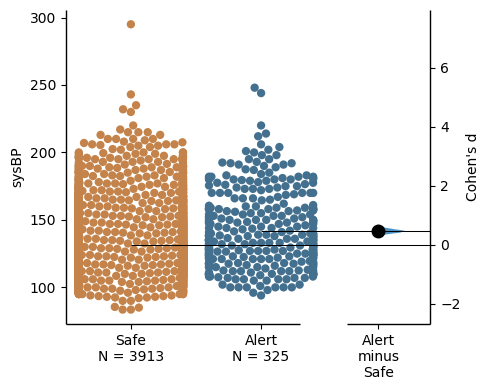

In [17]:
df["label"] = "Safe"
df.loc[df.risk == 1, "label"] = "Alert"

dabest_sysBP = dabest.load(df, x="label", y="sysBP", idx=("Safe", "Alert"))
dabest_sysBP.cohens_d.plot()


## Discussion

Our approach clearly demonstrated that the use of unsupervised machine learning through t-SNE, DBSCAN, and SOM are well suited for 10-Years CHD detection.

It is important to note that original results are also predictions. The confusion matrices computed in this notebook shouldn't be trusted as there are no ways to estimate the quality of our results. They may or may not be better than the original work. Otherwise, DBSCAN is taking noise into account while t-SNE is performing well on dimensionality reduction while a logistic regression may be sensitive to noise and lead to an higher rate of Type I and Type II errors. t-SNE is stochastic, meaning that at each iterations, the dimensionality reduction is different. However, we always get an "accuracy" between 80% and 90%. Andrews Plots are also showing that both original predictions and our predictions are consistent The original dataset seems however more spread than our predictions.

This can easily be explained because most variables are heavily correlated (higher BMI is often related to diabetes, which is related to glucose levels, etc...). This has for consequences that at each run, we can get a slightly different pearson correlations values.